<a href="https://colab.research.google.com/github/pranay8297/deep-learning-projects/blob/master/imdb_transfer_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from fastai import *
from fastai.text import *

In [2]:
path = untar_data(URLs.IMDB)

In [3]:
path.ls()

[PosixPath('/root/.fastai/data/imdb/README'),
 PosixPath('/root/.fastai/data/imdb/models'),
 PosixPath('/root/.fastai/data/imdb/train'),
 PosixPath('/root/.fastai/data/imdb/tmp_clas'),
 PosixPath('/root/.fastai/data/imdb/tmp_lm'),
 PosixPath('/root/.fastai/data/imdb/imdb.vocab'),
 PosixPath('/root/.fastai/data/imdb/unsup'),
 PosixPath('/root/.fastai/data/imdb/test')]

In [4]:
bs = 64
data = TextList.from_folder(path).filter_by_folder(['train', 'test']).split_by_rand_pct(0.1).label_for_lm().databunch(bs = bs)

In [5]:
data.show_batch()

/usr/local/lib/python3.6/dist-packages/fastai/text/data.py:339: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:766.)
  idx_min = (t != self.pad_idx).nonzero().min()


idx,text
0,"it , you 'll be , in the very least , surprised . \n \n xxmaj all the main players are very good . xxmaj bill xxmaj paxton did a great job directing those kids , and his acting is awesome . mcconaughey 's acting is solid throughout and fits the bill perfectly . \n \n xxmaj this movie challenges you to think . xxmaj is xxmaj dad"
1,"good father figure as he . i had three small children , no education , no financial support . i took it very , very hard . \n \n xxmaj within two years my in - laws attacked me verbally , physically , emotionally and spiritually demanding i grieve not in front of the children , and put on masks and showed people what they wanted to see ,"
2,"feature . xxmaj the difference between xxmaj charlie and xxmaj carface is that xxmaj charlie can learn and is willing to listen to others ; xxmaj anne xxmaj marie and his sidekick , xxmaj itchy . xxmaj carface will not even listen to the fat , ugly dog with the big glasses who happens to be closest to him . \n \n xxmaj carface attempts to murder the hero"
3,"development and xxmaj extras off the air this is officially the funniest thing on television right now . xxbos xxmaj you probably all already know this by now , but 5 additional episodes never aired can be viewed on xxunk i 've watched a lot of television over the years and this is possibly my favorite show , ever . xxmaj it 's a crime that this beautifully written and"
4,") a xxup town xxup like xxup alice ( 1956 ) his most noteworthy achievements  but he certainly milked every gripping situation in this case ( even if , reportedly , delays in filming saw xxmaj lee quitting his post prematurely leaving producer xxmaj ian xxmaj xxunk with the task of tying up loose ends ! ) . xxmaj anyway , worth special mention is the exquisite lighting"


In [6]:
learn = language_model_learner(data, arch = AWD_LSTM, drop_mult = 0.3)

In [8]:
learn.summary()

SequentialRNN
Layer (type)         Output Shape         Param #    Trainable 
RNNDropout           [70, 400]            0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
RNNDropout           [70, 1152]           0          False     
______________________________________________________________________
Linear               [70, 49888]          20,005,088 True      
______________________________________________________________________
RNNDropout           [70, 400]            0          False     
______________________________________________________________________

Total params: 20,005,088
Total trainable params: 20,005,088
Total non-trainable params: 0
Optimized with 'torch.optim.adam.Adam', betas=(0.9, 0.99)
Using true weight decay as discussed in https://www.fast.ai/2018/07/02/adam-weight-decay/ 
Loss fu

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


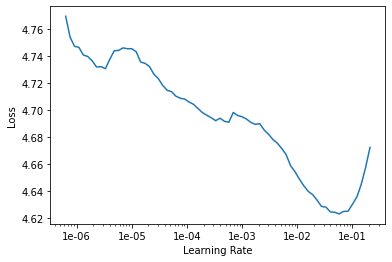

In [7]:
learn.lr_find()
learn.recorder.plot(skip_end=20)

In [8]:
learn.fit_one_cycle(1, slice(4e-02))

epoch,train_loss,valid_loss,accuracy,time
0,4.326374,4.164789,0.280990,09:53


In [14]:
learn.show_results()

text,target,pred
xxbos xxmaj jim xxmaj henson always seemed to put out wonderful television shows . xxmaj this was sadly one of,the shortest lived . xxmaj it was endearing to hear each tale with their delightful morals . xxmaj each episode,"the most of television xxmaj the was a , see the of of a own moments . xxmaj the of"
after watching this movie i can assure you that nothing but frustration and disappointment await you should you choose to,"go see this . xxmaj hey , xxmaj tim xxmaj burton , i used to be a big fan of","see to the movie xxmaj the , it custer xxmaj burton 's xxmaj 'm to be a little fan of"
"a great actioner with xxmaj flynn as dashing as ever , dehavilland as beguiling as ever , the young xxmaj",anthony xxmaj quinn getting a start as xxmaj crazy xxmaj horse and director xxmaj walsh as xxunk as ever in,"hitler xxmaj quinn 's married chance to a hitler , red , xxmaj xxmaj frank . xxmaj , xxmaj ."
", xxmaj lena and xxmaj mateo fall in love . xxmaj and , in xxmaj almodovar 's world it really","is that simple . xxmaj mateo , in the opening scene , has sex with a sexy young woman ,","is a the and xxmaj the xxmaj xxmaj particular end credits , is a with xxmaj woman girl girl who"
"xxmaj brewery . xxmaj they get a chance to harass the red team , with two feminists and two fun","- loving twins . xxmaj the white team of nerds are lead by xxmaj eddie xxmaj deezen , who was",") loving men ) xxmaj the xxmaj guy is xxmaj , a by the xxunk xxmaj murphy , who is"


In [9]:
learn.save('lm_stage_1')
learn.unfreeze()
learn.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


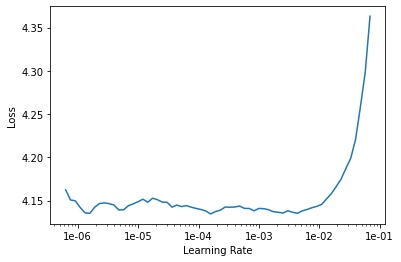

In [10]:
learn.recorder.plot(skip_end=20)

In [11]:
learn.fit_one_cycle(2, slice(1e-05, 4e-03), moms = (0.9, 0.8))

epoch,train_loss,valid_loss,accuracy,time
0,3.965282,3.923970,0.302383,11:20
1,3.863857,3.861275,0.308988,11:21


In [19]:
learn.show_results()

text,target,pred
xxbos xxmaj jim xxmaj henson always seemed to put out wonderful television shows . xxmaj this was sadly one of,the shortest lived . xxmaj it was endearing to hear each tale with their delightful morals . xxmaj each episode,"the best shows television xxmaj the was a , watch the of of a own voices . xxmaj the episode"
after watching this movie i can assure you that nothing but frustration and disappointment await you should you choose to,"go see this . xxmaj hey , xxmaj tim xxmaj burton , i used to be a big fan of","watch to this movie xxbos it , i custer xxmaj blake 's who 'm to be a xxmaj fan of"
"a great actioner with xxmaj flynn as dashing as ever , dehavilland as beguiling as ever , the young xxmaj",anthony xxmaj quinn getting a start as xxmaj crazy xxmaj horse and director xxmaj walsh as xxunk as ever in,"mr. xxmaj quinn as a job , a xxunk , jack , xxmaj xxmaj xxunk . xxmaj . xxmaj ."
", xxmaj lena and xxmaj mateo fall in love . xxmaj and , in xxmaj almodovar 's world it really","is that simple . xxmaj mateo , in the opening scene , has sex with a sexy young woman ,","is n't they , xxmaj the xxmaj who the end credits , is a with a woman xxmaj girl ,"
"xxmaj brewery . xxmaj they get a chance to harass the red team , with two feminists and two fun","- loving twins . xxmaj the white team of nerds are lead by xxmaj eddie xxmaj deezen , who was","- loving xxmaj ) xxmaj the characters guy is xxmaj , a by a xxunk xxmaj xxunk , a is"


In [31]:
learn.predict("I loved Cris Nolan's style of", 30, temperature=1., min_p = 0.001)

"I loved Cris Nolan's style of directing and was inspired to create a horror show . When John Derek gave up his Nolan - style , the real idea of having made"

In [12]:
learn.save_encoder('fine_tuned_enc')

In [15]:
temp_cls = TextList.from_folder(path, vocab= data.vocab)#.filter_by_folder(['train', 'test']).split_by_rand_pct(0.2).label_from_folder(classes = ['neg', 'pos']).filter_missing_y().databunch(bs = bs)
x = temp_cls.filter_by_folder(['train', 'test']).split_by_rand_pct(0.2).label_from_folder(classes = ['neg', 'pos'])

In [19]:
data_cls = x.databunch(bs = bs)

In [20]:
data_cls.show_batch()

text,target
xxbos xxmaj match 1 : xxmaj tag xxmaj team xxmaj table xxmaj match xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley vs xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit xxmaj bubba xxmaj ray and xxmaj spike xxmaj dudley started things off with a xxmaj tag xxmaj team xxmaj table xxmaj match against xxmaj eddie xxmaj guerrero and xxmaj chris xxmaj benoit . xxmaj according to the rules,pos
"xxbos "" xxmaj buffalo xxmaj bill , xxmaj hero of the xxmaj far xxmaj west "" director xxmaj mario xxmaj costa 's unsavory xxmaj spaghetti western "" xxmaj the xxmaj beast "" with xxmaj klaus xxmaj kinski could only have been produced in xxmaj europe . xxmaj hollywood would never dared to have made a western about a sexual predator on the prowl as the protagonist of a movie .",pos
"xxbos xxmaj to be a xxmaj buster xxmaj keaton fan is to have your heart broken on a regular basis . xxmaj most of us first encounter xxmaj keaton in one of the brilliant feature films from his great period of independent production : ' xxmaj the xxmaj general ' , ' xxmaj the xxmaj navigator ' , ' xxmaj sherlock xxmaj jnr ' . xxmaj we recognise him as",neg
"xxbos xxmaj pier xxmaj paolo xxmaj pasolini , or xxmaj pee - pee - pee as i prefer to call him ( due to his love of showing male genitals ) , is perhaps xxup the most overrated xxmaj european xxmaj marxist director - and they are thick on the ground . xxmaj how anyone can see "" art "" in this messy , cheap sex - romp concoction is",neg
"xxbos i was recently given this film on xxup dvd as a gift , and was unsure at first if it would appeal ( although one of my favourite actors has a leading role ) . xxmaj in fact , it 's on its way to becoming a favourite . \n \n xxmaj first of all : thankfully , it 's * not * the same as the book",pos


In [22]:
classifier = text_classifier_learner(data_cls, AWD_LSTM)
classifier.load_encoder('fine_tuned_enc')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (40000 items)
x: TextList
xxbos mcconaughey in a horror / thriller ? i had to see this . i was pleasantly surprised . 
 
  xxmaj the plot is told in flashback mode , and it concerns an otherwise normal and happy family of three going through a very bizarre predicament . i ca n't say much more without spoiling the whole movie , sorry . xxmaj just know that if you decide to watch it , you 'll be , in the very least , surprised . 
 
  xxmaj all the main players are very good . xxmaj bill xxmaj paxton did a great job directing those kids , and his acting is awesome . mcconaughey 's acting is solid throughout and fits the bill perfectly . 
 
  xxmaj this movie challenges you to think . xxmaj is xxmaj dad crazy ? xxmaj is there a xxmaj god ? xxmaj do xxmaj demons exist ? xxmaj how far would you go to right a wrong . xxmaj and what is " right " anyway ? i 'm still thinking . 
 
  xxmaj and thus i recommend " xxmaj frailty " . 7 / 10 and thi

In [23]:
classifier.freeze()
classifier.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


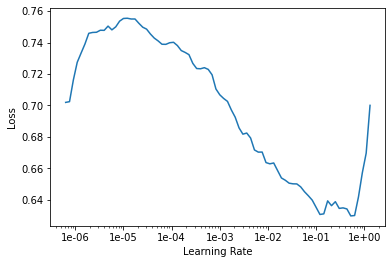

In [24]:
classifier.recorder.plot()

In [25]:
classifier.fit_one_cycle(3, slice(1e-1))

epoch,train_loss,valid_loss,accuracy,time
0,0.516311,0.357609,0.852800,02:27
1,0.479803,0.314498,0.867400,02:27
2,0.458985,0.310116,0.874600,02:26


In [26]:
classifier.freeze_to(-2)
classifier.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


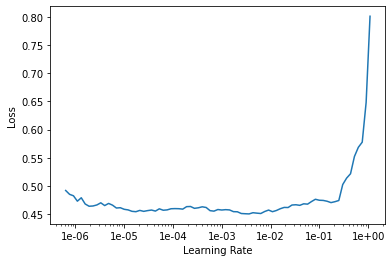

In [27]:
classifier.recorder.plot()

In [29]:
classifier.fit_one_cycle(2, slice(1e-02))

epoch,train_loss,valid_loss,accuracy,time
0,0.406740,0.366666,0.859600,02:57
1,0.371502,0.249121,0.901400,02:57


In [30]:
classifier.freeze_to(-4)
classifier.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


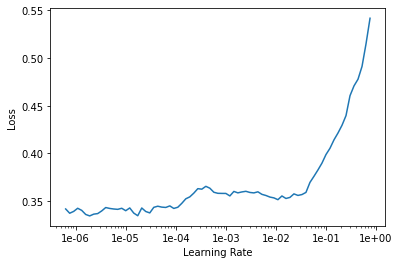

In [31]:
classifier.recorder.plot()

In [32]:
classifier.fit_one_cycle(2, slice(4e-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.305452,0.208141,0.920000,05:38
1,0.260063,0.195834,0.926600,05:38


In [33]:
classifier.unfreeze()
classifier.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


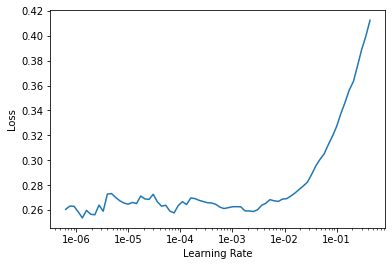

In [34]:
classifier.recorder.plot()

In [ ]:
classifier.fit_one_cycle(3, slice(1e-06, 1e-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.242902,0.194828,0.928500,05:40
1,0.252940,0.191382,0.927200,05:39
